<h2 style = "text-align:center" ><b>EEG</b> - Prédiction des Mouvements Imaginaires de la Main</h2>

---

# **1. Description du projet**
- Introduction :  
L’électroencéphalogramme (EEG) est une technique d’imagerie cérébrale utilisée pour étudier les activités du cerveau.  
En plaçant des capteurs sur le cuir chevelu, l’activité électrique du cerveau est enregistrée, ce qui permet de comprendre les fonctionnements cérébraux et d’identifier certains schémas que l’on peut ensuite attribuer à des comportements précis.  
Un des schémas d'EEG qui a été beaucoup étudié est l’imagerie motrice (IM), ou le mouvement imaginaire de la main.  
Les IM créent des schémas bien définis qui peuvent être détectés.  
Le but de ce projet est de créer et d’entraîner un programme permettant de prédire si l’IM d’une personne correspond à un mouvement de la main droite ou de la main gauche.  
# **2. Étapes du projet**
- Prétraitement des Données :  
Les données EEG sont sujettes à des artefacts ou des erreurs de collecte dues à des mouvements parasites ou des interférences.  
Il est donc nécessaire d'appliquer un système de prétraitement des données pour réduire le bruit et extraire les bandes de fréquences pertinentes.

- Segmentation des données et extraction des caractéristiques :  
Les données EEG sont présentées comme un flux continu. Il est donc important, pour une meilleure analyse, de diviser les données en segments temporels correspondant à l’IM.  
Ensuite, identifier et extraire les caractéristiques pertinentes des signaux EEG associées aux IM est essentiel.  
Cela comprend la puissance et d'autres spécificités de l’activité électrique qui définissent les IM.

- Analyse statistique exploratoire :  
Utiliser les outils d’analyse exploratoire pour mieux comprendre les données et identifier les tendances ou les patterns significatifs.

- Entraînement du modèle :  
Entraîner un modèle permettant de distinguer les différences entre les IM des mains droite et gauche.  
Optimiser le modèle et évaluer sa performance sur un ensemble de test.

- Conclusion :  
Ces étapes sont cruciales pour développer un programme efficace de prédiction des mouvements imaginaires de la main basé sur les données EEG.
# **3. Ressources**
- Données   
https://www.kaggle.com/competitions/ucsd-neural-data-challenge/overview  
- Bibliographie  
https://www.bbci.de/competition/iv/desc_2b.pdf
# **4. Liens utils**
- SciPy - *open-source software for mathematics, science, and engineering*  
https://docs.scipy.org/doc/scipy/index.html  
https://docs.scipy.org/doc/scipy/reference/signal.html  
- MNE - *MEG + EEG Analysis & Visualisation*
   - Accueil  
   https://mne.tools/stable/index.html

   - MNE - Data structures from arbitrary data  
   https://mne.tools/stable/auto_tutorials/io/10_reading_meg_data.html#creating-mne-data-structures-from-arbitrary-data-from-memory
   
   - MNE - EEG Preprocessing  
   https://mne.tools/dev/auto_tutorials/preprocessing/index.html  

- pyRiemann - *Biosignals classification with Riemannian geometry*  
https://pyriemann.readthedocs.io/en/latest/  
- neurodsp - *Neuro Digital Signal Processing Toolbox*  
https://neurodsp-tools.github.io/neurodsp/index.html#
- Rythme Mu  
https://fr.wikipedia.org/wiki/Rythme_Mu
- Spectrogram from EEG  
https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg
- Divers  
https://signalprocessingsociety.org/  
https://fr.wikipedia.org/wiki/Filtre_de_Butterworth  
https://fr.wikipedia.org/wiki/Moyenne_mobile  
https://terpconnect.umd.edu/~toh/spectrum/Differentiation.html  
https://perso.etis-lab.fr/ghaffari/2014_CCMB_Floride_USA.pdf  
https://www.youtube.com/watch?v=wB417SAbdak&list=PLXc9qfVbMMN2TAoLHVW5NvNmJtwiHurzw  
https://fastercapital.com/fr/sujet/identification-des-artefacts-de-traitement-du-signal-dans-des-sc%C3%A9narios-r%C3%A9els.html#:~:text=L'inspection%20visuelle%20est%20la,des%20pertes%20et%20du%20bruit.  
   - Z-Score Normalisation  
   https://fr.wikipedia.org/wiki/Cote_Z_(statistiques)  
   https://typeset.io/questions/why-is-z-score-normalisation-necessary-in-pre-processing-eeg-1xv5jepyq5  

   - Traitement numérique du signal  
   https://fr.wikipedia.org/wiki/Traitement_num%C3%A9rique_du_signal  
   - Ondelette  
      - Wiki  
      https://fr.wikipedia.org/wiki/Ondelette  

      - L’analyse par ondelettes dans la vie de tous les jours  
      https://interstices.info/lanalyse-par-ondelettes-dans-la-vie-de-tous-les-jours/  

      - A guide for using the Wavelet Transform in Machine Learning  
      https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
      
      - pyWavelets - *open source wavelet transform*  
      https://pywavelets.readthedocs.io/en/latest/

      - Ondelettes et applications  
      https://www.i2m.univ-amu.fr/~caroline.chaux/GEOMDATA/TI-te5215.pdf

   - Maximum de vraisemblance  
   https://pmarchand1.github.io/ECL8202/notes_cours/03-Maximum_vraisemblance.html  
   https://fr.wikipedia.org/wiki/Maximum_de_vraisemblance#:~:text=En%20statistique%2C%20l'estimateur%20du,maximisant%20la%20fonction%20de%20vraisemblance  

   - Transformation de Fourier discrète  
   https://fr.wikipedia.org/wiki/Transformation_de_Fourier_discr%C3%A8te  
      - La Transformation de Fourier n’est pas adaptée à l’analyse des signaux non stationnaires.
   - Neural Data Science in Python  
   https://neuraldatascience.io/intro.html

   - Preprocessing of EEG  
   https://www.frontiersin.org/articles/10.3389/fninf.2015.00016/full#:~:text=The%20depositable%20preprocessing%20pipeline%20consists,with%20a%20low%20recording%20SNR  
   https://typeset.io/papers/preprocessing-of-eeg-4go8vhcbty  
   https://learn.neurotechedu.com/preprocessing  
   https://g0rella.github.io/gorella_mwn/preprocessing_eeg.html  
   
   - Biblio :  
   https://perso.telecom-paristech.fr/bloch/P6Image/ondelettestrsp.pdf  
   https://www.math.u-bordeaux.fr/~jbigot/Site/Enseignement_files/ondelettesIMAT.pdf  
   http://w3.cran.univ-lorraine.fr/perso/radu.ranta/pdf/cours_deb_ond%28fr%29.pdf
   
   - Digital Filtering  
   http://notebooks.pluxbiosignals.com/notebooks/Categories/Pre-Process/digital_filtering_eeg_rev.html

   - Processus stationnaire  
   https://fr.wikipedia.org/wiki/Processus_stationnaire

   - Analyse en composantes principales  
   https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales#:~:text=L'ACP%2C%20d%C3%A9sign%C3%A9e%20en%20g%C3%A9n%C3%A9ral,une%20grandeur%20physique%2C%20comme%20les

In [1]:
### Chargement des différentes librairies

import sys, os, gc

sys.path.insert(0, os.path.dirname(os.getcwd()))

from src.thot.sesh import *

import librosa

from sklearn import preprocessing, model_selection, ensemble, svm, neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier

# from scipy.fft import fft
# from sktime import pycatch22

%matplotlib inline

In [2]:
### Deprecated

### Ce DataFrame sera utilisé pour l'étude de des signaux.
# @deprecated("Plus utilisé dans le cadre de ce projet")
def fancy_df(df : pd.DataFrame, events : list, hands : dict, size : int,
             expend : int = 0) -> tuple[pd.DataFrame, list] : # deprecated
    df_cpy = pd.DataFrame({'C3_4'  : df[['C3', 'C4']].sum(axis = 1), # Somme des signaux 'C3' et 'C4'.
                            # 'EventStart' : df['EventStart'],       # Survenue d'un évènement lié à une des mains.
                           'Hand'  : 0,                              # Activité liée à l'une des mains.
                           'Left'  : 0,                              # Activité liée à la main gauche.
                           'Right' : 0})                             # Activité liée à la main droite.
    evts  = list(zip(np.where(df['EventStart'] == 1)[0], events))
    size += 2 * expend
    # df_cpy['zCore'] = stats.zscore(df['C3_4'])

    for i, j in evts :
        i                        -= expend
        fin                       = range(i, i + size)
        df_cpy.loc[fin, 'Hand']   = np.ones(size)
        df_cpy.loc[fin, hands[j]] = np.ones(size)

    return df_cpy, evts # [i[0] for i in evts]

### 
# @deprecated("Plus utilisé dans le cadre de ce projet")
def left_right_old(df : pd.DataFrame, events : list, size : int, canals, hand : int = 0,
                      expend : int = 0) -> pd.DataFrame :
    lp    = range(len(canals))
    res   = [[] for _ in lp]
    size += expend * 2

    for i in events :
        i   -= expend
        fin = range(i, i + size)

        for k, c in enumerate(canals) :
            res[k] = np.append(res[k], df.loc[fin, c].values)

    return pd.DataFrame({'signal_epoched' : res, 'canal' : canals, 'hand' : hand, 'data_split' : [events for _ in lp]})

d = 511

print((d >> 5) << 5)
print((d // 32) * 32)

In [2]:
### Déclaration de constantes

# Fréquence d'échantillonnage - Hz (Nombre de valeur / sec)
SAMPLE_RATE : int = 250
# Temps additionel pour étendre le domaines d'étude.
LAG : int    = SAMPLE_RATE >> 3     # Décalage de 1/8 de sec
# Epoque en sec donnée en nombre d'échantillon consectutif # 2" de données (multiple de 2)
SCOPE : int  = 2 << math.ceil(math.log2(SAMPLE_RATE))
# Deux enregistrements bipolaires + neutre
eeg_Channels = ['C3', 'C4', 'Cz']
# Liste des cannaux eeg associés aux évènement 0 et 1
eeg_left     = [f'{c}_0' for c in eeg_Channels]
eeg_right    = [f'{c}_1' for c in eeg_Channels]
full_eeg     = eeg_left + eeg_right
# Trois enregistrements musculaires
ecg_Channels = ['EOG:ch01', 'EOG:ch02', 'EOG:ch03']
# Liste de tous les cannaux des dataframes
all_channels = eeg_Channels + ecg_Channels
# Correspondance pour la classification
hands_event  = {0 : 'Left', 1 : 'Right'}
# Les bandes de fréquences d'intérêt
eeg_bands    = {'Delta': (.1, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30), 'Gamma': (30, 120)}
# Coefficients pour filtres Butterworth numérique d'ordre N pour le filtrage passe-bande
bands_coeff  = {band : butter_bandpass(low, high, SAMPLE_RATE) for band, (low, high) in eeg_bands.items()}
# Nombre dévènement à prédir
num_events   = range(len(hands_event))

In [3]:
### Acquisition des données

target  = "../data/data.zip"
count   = len('train/')
fics    = [x[count :] for x in files_in_zip(target, directory = 'train')]

# Acquisition des fichiers du répertoir dans le fichier zip
trains_csv = csv_in_zip(target, directory = 'train', files = fics)
labels_csv = csv_in_zip(target, directory = 'y_train_only', files = fics)

notes   = filename(fics)
headers = [f"{t} . {i}" for i, t in enumerate(notes)]
count   = range(len(trains_csv))

# fics    = [f'B0{i}0{j}T.csv' for i in range(1, 9) for j in range(1, 4)]
# df_train_pkl = pkl_in_zip(path, fichier_specifique = 'epoched_train.pkl')

In [4]:
### Pré-traitement des données

Tracks  = []        #
Tries   = [[], []]  # Les époques pour tous les cannaux et tous les évènements.
Spots   = [[], []]  # Apparitions des évènements
# Pour la standardisation du nombre d'échantillon max conservé
ceil    = min([len(labels_csv[i]['EventType']) for i in count])
merge   = False

# Extraction des données relavitives à l'apparition des évènements.
for j in count :
    data   = trains_csv[j]
    types  = labels_csv[j]['EventType'][: ceil]
    events = np.where(data['EventStart'] == 1)[: ceil]

    Tracks.append(zero_removal(data['C3'], 75))

    for j in num_events :
        Spots[j].append(np.array(*events)[*np.where(types == j)])

        room = event_epochs(Spots[j][-1], SCOPE, LAG)

        Tries[j].append([full_event(data[c], room, merge)for c in eeg_Channels])

# cpy = Tries.copy()

# Regroupement des données en fonction du type de l'évènement et du cannal d'observation
if merge :
    Tries = [[[np.append([], T[j :: 3]) for T in Tries[i]] for j in range(3)] for i in num_events]
else :
    store = [[[], [], []], [[], [], []]]
    
    [[[[store[i][j].append(G) for G in X] for j, X in enumerate(T)] for T in Tries[i]] for i in num_events]

    Tries = store
    # res = [[np.concatenate(np.stack(cpy[i], axis = 1)[j], axis = 0) for j in range(3)] for i in n_type]

# titled = [f"S{c + 1:0000}" for c in range(len(Tries[0][0][0]))]

eras = [pd.DataFrame(dict(zip(eeg_Channels, [pd.Series(X) for X in Tries[i]]))) for i in num_events]

# df_0 = pd.DataFrame(dict(zip(eeg_Channels, [pd.Series(X) for X in Tries[0]])))
# df_1 = pd.DataFrame(dict(zip(eeg_Channels, [pd.Series(X) for X in Tries[1]])))

# print(np.shape(Tries))

del Tries

gc.collect();

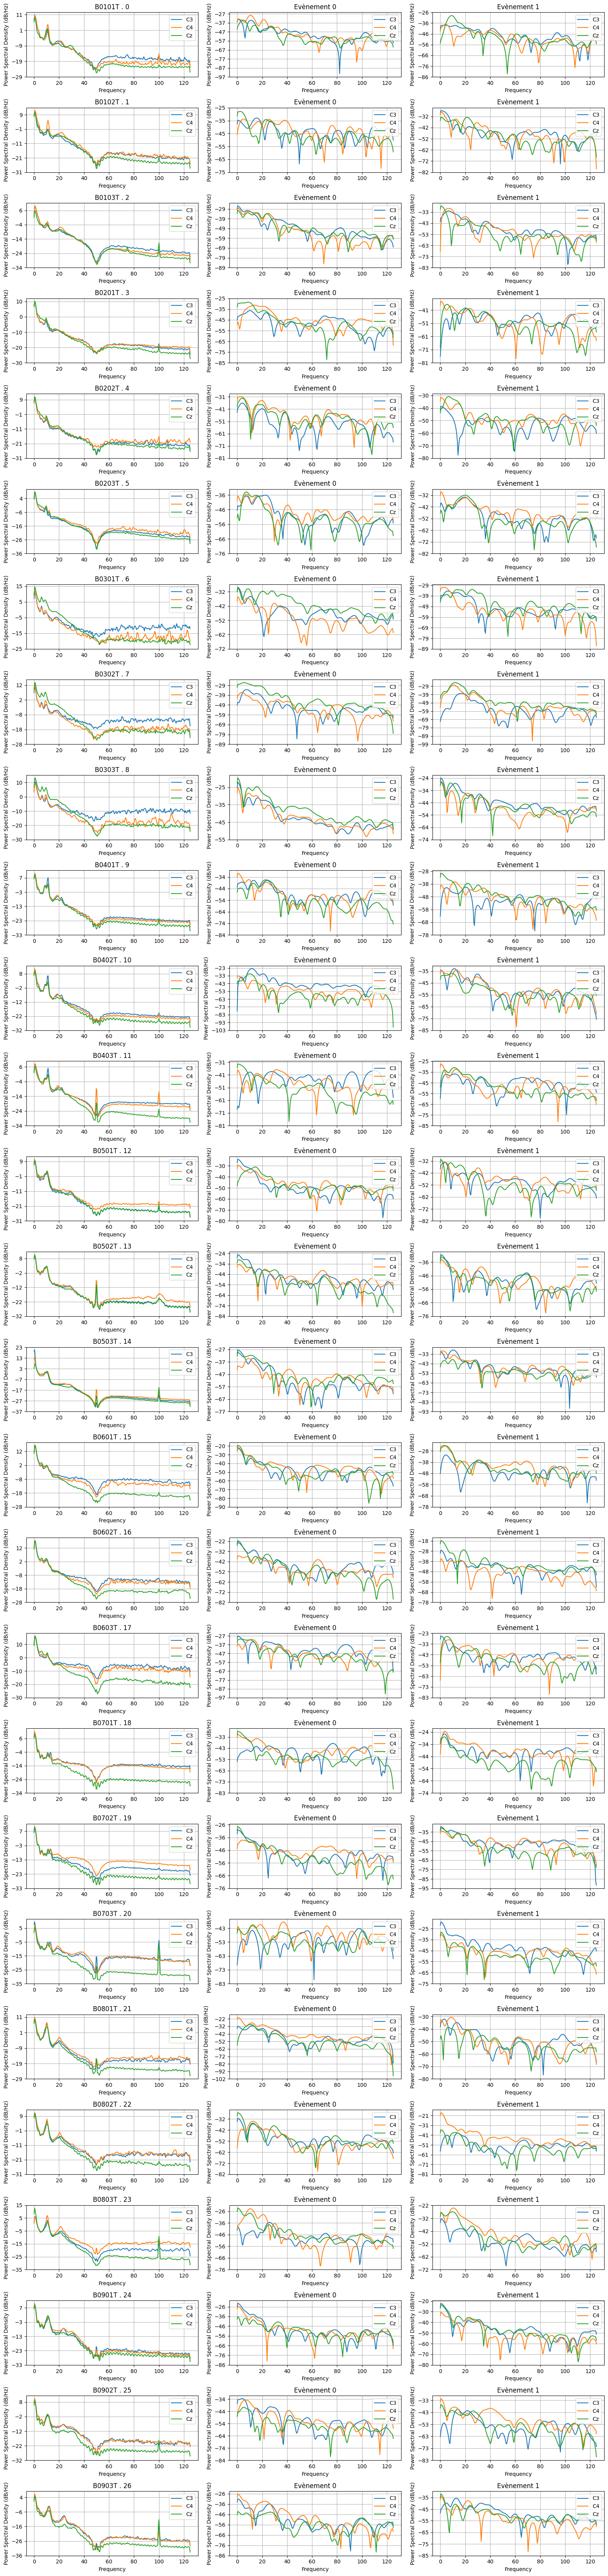

In [5]:
### Densité spectral du signal / Visualisation

plot_psd(trains_csv, eras, rate = SAMPLE_RATE, Channels = eeg_Channels, titled = headers)

In [ ]:
### Extraction époque / visualisation

for j in range(len(fics))[:: 3] :
    plot_signal(trains_csv[j], Tracks[j], Spots[0][j], Spots[1][j], channels = eeg_Channels,
                period = SCOPE, lag = LAG, title = headers[j])

In [ ]:
### Test de décomposition des signaux / visualisation

# Test de décomposition des signaux en bandes de fréquences spécifiques compatibles avec les répartitions usuelles
# dans le domaine des EEG ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

for df, token in zip(eras, ['Gauche', 'Droite']) :
    print(f"Exemples - Évènement Discriminé Main {token}")
    plot_wavelets(df, bands_coeff, eeg_Channels, scope = 30, headers = headers)

In [ ]:
### Test de visualisation des spectrogrammes

def img_spectrogram(raw : Vector, rate : int, nfft : int = 1 << 10) -> Vector :
    return librosa.feature.melspectrogram(y = raw, sr = rate, hop_length = 1, 
                            n_fft = nfft, n_mels = 32, fmin = 0, fmax = 20, win_length = 32)

def spectrogram(data : Board, rate : int, channels : Clause, n_row : int = 5, n_col : int = 12) :
    sample = np.random.default_rng().integers(data.shape[0], size = n_row)

    sample.sort()

    plt.figure(figsize = (18, 2 * .48 * n_row))

    pos = 0

    for k in sample :
        for c in channels :
            x   = normalized(data[c][k])
            raw = img_spectrogram(raw = x, rate = rate)
            pos += 1
            
            plt.subplot(n_row, n_col, pos)
            plt.title(f"{((pos - 1) // 3) + 1} . {k} - {c}", fontsize = 8)
            librosa.display.specshow(data = 1 - raw, sr = rate, hop_length = 1)
            
            # pos = n_col * (i >> 1) + j
            # f, t, Sxx = signal.spectrogram(x, rate)
            # plt.subplot(n_row, n_col, pos + 4)
            # plt.pcolormesh(t, f, 1 - Sxx, shading = 'gouraud')

    plt.tight_layout()
    plt.show();

for i, t in zip(num_events, ['Gauche', 'Droite']) :
    print(f"Exemples - Évènement Discriminé Main {t}")
    spectrogram(eras[i], SAMPLE_RATE, eeg_Channels, 160)

In [ ]:
### Test PCA - (Non cloncluant)

nca = 250
sc  = StandardScaler()
pca = PCA(nca)

_, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 5))

for j, d in enumerate(eras) :
    for j, c in enumerate(eeg_Channels) :
        Z = sc.fit_transform(list(d[c].to_list())) # 
        principal_components = pca.fit_transform(Z)
        
        ax[j, j].plot(range(nca), np.cumsum(pca.explained_variance_ratio_))
        ax[j, j].set_title(f'{c} . {j}')

plt.tight_layout()
plt.show();

In [ ]:
### MNE époque - test

raw_csv = trains_csv[0][eeg_Channels]
info    = mne.create_info(ch_names = eeg_Channels, sfreq = SAMPLE_RATE, ch_types = 'eeg')
raw_mne = mne.io.RawArray(raw_csv.T * 1e-6, info)

tmin, tmax = -0., 1
events  = mne.find_events(raw_mne, stim_channel = 'C3')
# event_id = dict(C3 = 1, aud_r = 2, vis_l = 3, vis_r = 4)

events = np.where(trains_csv[0]['EventStart'] == 1)[0]

# raw = mne.io.Raw(raw_mne, preload = True)
# raw.filter(2, None, method = 'iir')           # replace baselining with high-pass
# events = mne.read_events(event_fname)

# raw.info['bads'] = ['MEG 2443']  # set bad channels
# picks = mne.pick_types(info, meg = 'grad', eeg = True, eog = False, exclude = 'bads')
# Read epochs
epochs = mne.Epochs(raw_mne, np.array([events, events, events]).T, None, tmin, tmax, proj = False,
                    picks = None, baseline = None, preload = True, verbose = False) # event_id picks

# labels = epochs.events[::5, -1]

# events

# raw_mne.plot();

# raw_mne['C3'][0][0], len(df_train_csv[2]['Cz'])

epochs

In [ ]:
extra = pd.concat([share_out(train, h0, h1, SCOPE, eeg_Channels) for train, h0, h1 in zip(trains_csv, case_A, case_B)])

extra.reset_index(drop = True, inplace = True)
extra.fillna(0, inplace = True)

extra

In [ ]:
df_X = extra.drop(columns = ['data_split', 'hand', 'C3_dum', 'C4_dum', 'Cz_dum'])
y    = extra['hand']

X_train, X_test, y_train, y_test = train_test_split(df_X, y, test_size = .2)

scaler = preprocessing.StandardScaler()

X_train_scaled = scaler.fit_transform(X_train, y_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# K-plus proches voisins
clf1 = neighbors.KNeighborsClassifier()
# SVM (support vector machine)[, 'auto']
clf2 = svm.SVC(gamma = 'scale')
# RandomForest
clf3 = ensemble.RandomForestClassifier(n_jobs = -1)

Voting_clf = VotingClassifier(estimators = [('knn', clf1), ('svm', clf2), ('rf', clf3)], voting = 'hard')
# cv3        = model_selection.KFold(n_splits = 3, random_state = 42, shuffle = True)

for clf in [clf1, clf2, clf3] :
    print(f"● {clf} :")

    scores : dict = model_selection.cross_validate(clf, X_train, y_train, cv = 3, scoring = ['accuracy'])
    
    # r = abs(scores['test_neg_mean_squared_error'])
    # print(f"  - Mean square ;{r.mean(): .3} (±{r.std(): .2})")
    r = scores['test_accuracy']
    print(f"  - Accuracy    ;{r.mean(): .3} (±{r.std(): .2})")
    print()

In [24]:
params = {
    ## K-plus proches voisins
    'knn__n_neighbors' : range(2, 5),
    ## SVM
    'svm__C'      : [0.1, 1, 5],
    'svm__kernel' : ['linear', 'sigmoid', 'rbf'],
    ## RandomForest
    # 'rf__max_features'      : ['sqrt', 'log2', None],
    # 'rf__min_samples_split' : range(2, 32, 2),
    # , ('rf', clf3), ('rf', clf3)
    'estimators': [[('knn', clf1), ('svm', clf2)], [('knn', clf1), ('svm', clf2)]] 
    }

grid = model_selection.GridSearchCV(estimator = Voting_clf, param_grid = params, cv = 5) \
    .fit(X_train_scaled, y_train)

# parametres = {'max_features' : ['log2', 'sqrt', None], 'min_samples_split' : range(2, 32, 2)}

# vclf = model_selection.GridSearchCV(estimator = clf3, param_grid = parametres, cv = 3) \
#     .fit(X_train_scaled, y_train)

In [ ]:
print(grid.best_estimator_)
print(grid.best_score_)
print('score train :', grid.score(X_train_scaled, y_train))
print('score test :', grid.score(X_test_scaled, y_test))

# print(vclf.best_estimator_, vclf.best_params_, vclf.best_score_)
# print('score train :', grid.score(X_train_scaled, y_train), vclf.score(X_train_scaled, y_train))
# print('score test  :', grid.score(X_test_scaled, y_test), vclf.score(X_test_scaled, y_test))

In [ ]:
df_train_cpy, event_start = fancy_df(trains_csv, labels_csv['EventType'], hands_event, SCOPE)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize = (24, 5), sharey = True)
sig = .05

axes.plot(trains_csv['C3'])

for p in event_start :
    axes.axvspan(p[0] - SCOPE / 2, p[0] + 1.5 * SCOPE, facecolor = 'orangered', alpha = .5)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Score')

In [ ]:
pos    = 16
start  = event_start[pos][0]
entrant  = start + SCOPE
data   = df_train_cpy['C3_4'][start : entrant]
smooth = data.copy()
n      = 5
alpha  = 1 / 3
dec    = int(n / alpha)

plt.figure(figsize = (24, 5))
plot_window(trains_csv, ['C3', 'C4', 'C3 + C4'], start, SCOPE)

# Lissage des hautes fréquences
for _ in range(n) :
    smooth = simple_exponential_smoothing(smooth, alpha, 0)

smooth = pd.Series(index = range(start, entrant + n - dec), data = smooth[dec :])

# plt.plot(raw - smooth, label = hands[event_start[pos][1]])
plt.plot(smooth, '--', label = hands_event[event_start[pos][1]])
plt.legend()
plt.show()